# Import Libraries

In [347]:
# Core
import pandas as pd
import numpy as np
import sklearn
import math
import wbdata
from datetime import datetime
import geopandas as gpd
import country_converter as coco

# Preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


# Models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Funciones

In [348]:
def load_world_bank_data(indicators, countries='all', start_year=2019, end_year=2019):
    data_date = (datetime(start_year, 1, 1), datetime(end_year, 12, 31))
    df = wbdata.get_dataframe(indicators, country=countries, date=data_date)
    return df

In [349]:
def preprocess_data(df):

    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(imputer.fit_transform(df.iloc[:, 2:]), columns=df.columns[2:], index=df.index)
    
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_imputed)
    
    return pd.DataFrame(df_scaled, columns=df.columns[2:], index=df.index)

In [350]:
def calculate_kmo(df_1_scaled):
    n, p = df_1_scaled.shape
    sigma_squared = np.var(df_1_scaled, axis=0)
    off_variance = np.sum(np.diag(np.cov(df_1_scaled)))

    kmo_value = (n * sigma_squared.sum()) / (off_variance + n * sigma_squared.sum())
    return kmo_value

In [351]:
def find_optimal_k(data, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    return distortions

# Load Dataset

In [352]:
indicators = {
    'NY.GDP.PCAP.CD': 'PIB per cápita (USD actuales)',
    'NY.GDP.MKTP.KD.ZG': 'Crecimiento del PIB (% anual)',
    'BX.KLT.DINV.WD.GD.ZS': 'Inversión extranjera directa, entradas netas (% del PIB)',
    'SI.POV.GINI': 'Índice de Gini',
    'SG.GEN.PARL.ZS': 'Proporción de escaños ocupados por mujeres en los parlamentos nacionales (%)',
    'SL.TLF.CACT.FE.ZS': 'Participación laboral femenina (% de la población femenina)',
    'EN.ATM.CO2E.PC': 'Emisiones de CO2 (toneladas métricas per cápita)',
    'EG.FEC.RNEW.ZS': 'Energía renovable consumida (% del total de energía consumida)',
    'AG.LND.FRST.ZS': 'Deforestación neta (% del cambio de cobertura forestal)',
    'SE.ADT.LITR.ZS': 'Tasa de alfabetización de adultos (% de personas de 15 años y más)',
    'SE.XPD.TOTL.GD.ZS': 'Gastos en educación (% del PIB)',
    'SE.SCH.LIFE': 'Esperanza de vida escolar (años)',
    'SL.UEM.TOTL.ZS': 'Tasa de desempleo (% de la población activa)',
    'SP.DYN.LE00.IN': 'Esperanza de vida al nacer (años)',
    'SI.POV.DDAY': 'Tasa de pobreza (% de la población viviendo con menos de $1.90 al día)'
}

In [353]:
df = load_world_bank_data(indicators)
df.reset_index(inplace=True)

In [354]:
df.head()


,country,PIB per cápita (USD actuales),Crecimiento del PIB (% anual),"Inversión extranjera directa, entradas netas (% del PIB)",Índice de Gini,Proporción de escaños ocupados por mujeres en los parlamentos nacionales (%),Participación laboral femenina (% de la población femenina),Emisiones de CO2 (toneladas métricas per cápita),Energía renovable consumida (% del total de energía consumida),Deforestación neta (% del cambio de cobertura forestal),Tasa de alfabetización de adultos (% de personas de 15 años y más),Gastos en educación (% del PIB),Esperanza de vida escolar (años),Tasa de desempleo (% de la población activa),Esperanza de vida al nacer (años),Tasa de pobreza (% de la población viviendo con menos de $1.90 al día)
0,Afghanistan,497.741429,3.911603,0.124496,NaN,27.868852,18.402000,0.297564,18.510000,1.852782,NaN,NaN,NaN,11.082000,63.565000,NaN
1,Africa Eastern and Southern,1507.982881,2.040617,1.497711,NaN,29.274564,64.487216,0.915294,63.387090,30.391626,72.634972,4.541950,NaN,7.426777,63.755678,NaN
2,Africa Western and Central,1812.446822,3.200919,1.512345,NaN,15.398773,54.417315,0.490837,75.328928,19.901215,59.511719,3.100235,NaN,4.277483,57.555796,NaN
3,Albania,5396.214243,2.087712,7.797920,30.1,29.508197,52.815000,1.749462,40.110000,28.791971,NaN,3.916240,14.81892,11.470000,79.282000,0.0
4,Algeria,4021.983266,1.000000,0.804144,NaN,25.757576,16.456000,3.994402,0.160000,0.814110,NaN,6.036907,NaN,12.275000,76.474000,NaN


# Preprocess Data

In [355]:
df_processed = preprocess_data(df)
df_processed.head()

,Crecimiento del PIB (% anual),"Inversión extranjera directa, entradas netas (% del PIB)",Índice de Gini,Proporción de escaños ocupados por mujeres en los parlamentos nacionales (%),Participación laboral femenina (% de la población femenina),Emisiones de CO2 (toneladas métricas per cápita),Energía renovable consumida (% del total de energía consumida),Deforestación neta (% del cambio de cobertura forestal),Tasa de alfabetización de adultos (% de personas de 15 años y más),Gastos en educación (% del PIB),Esperanza de vida escolar (años),Tasa de desempleo (% de la población activa),Esperanza de vida al nacer (años),Tasa de pobreza (% de la población viviendo con menos de $1.90 al día)
0,0.438559,0.048427,0.409241,0.455002,0.170422,0.008286,0.192232,0.019005,0.726035,0.234806,0.397844,0.419048,0.330178,0.084295
1,0.384691,0.054008,0.503630,0.477952,0.762054,0.027685,0.658294,0.311739,0.610943,0.321066,0.161929,0.279573,0.336087,0.464430
2,0.418097,0.054068,0.586799,0.251409,0.632779,0.014355,0.782313,0.204135,0.424365,0.212695,0.161929,0.159403,0.143964,0.576913
3,0.386047,0.079615,0.227723,0.481766,0.612209,0.053881,0.416554,0.295331,0.937156,0.274032,0.713157,0.433854,0.817217,0.000000
4,0.354730,0.051189,0.361716,0.420532,0.145439,0.124380,0.001662,0.008351,0.726035,0.433439,0.590663,0.464571,0.730203,0.021745


# Matriz de Correlacion

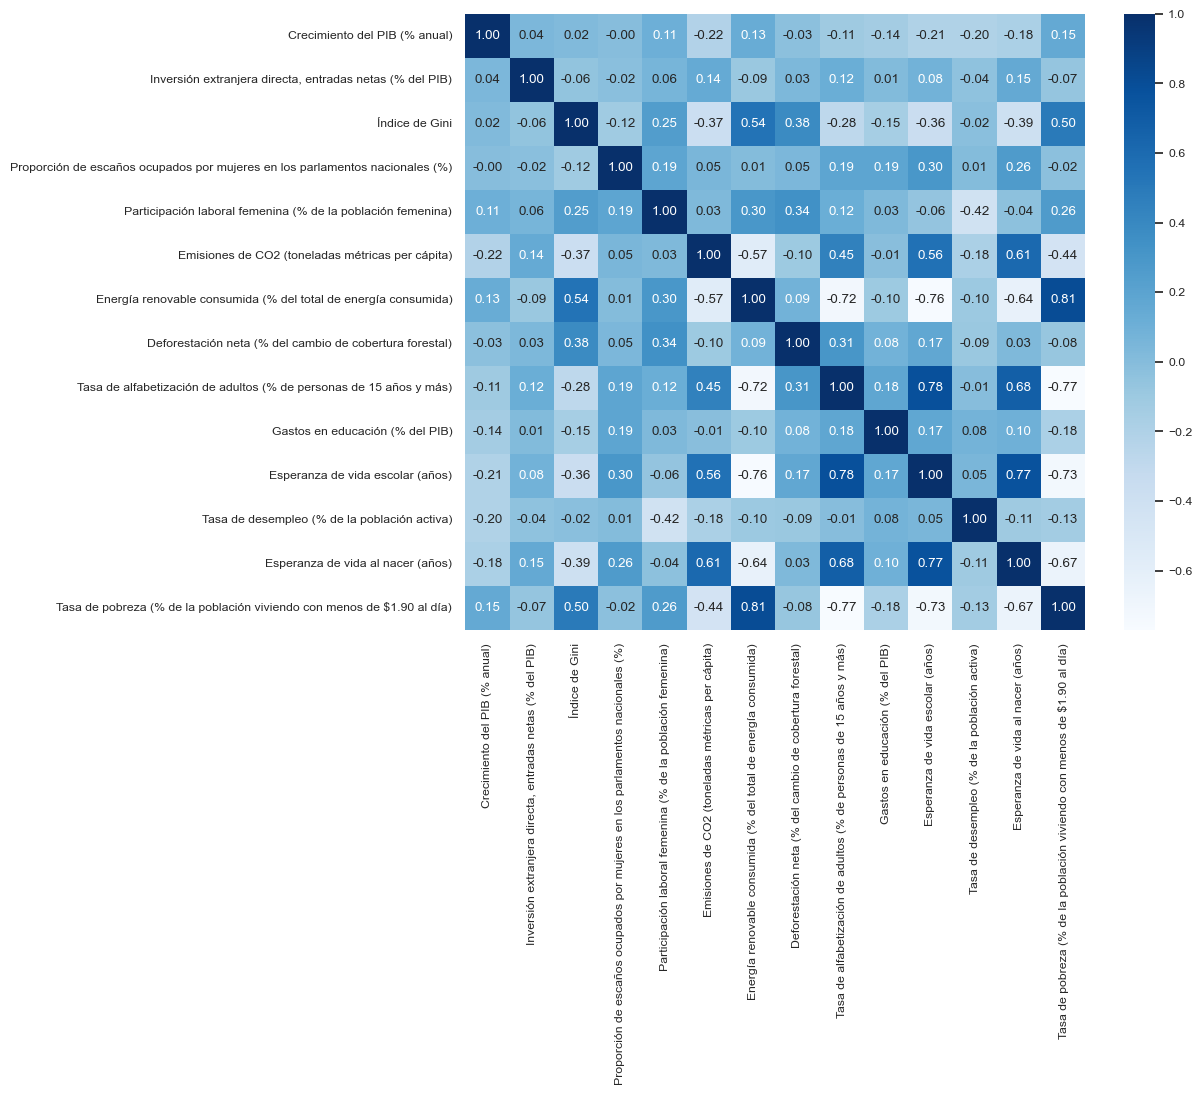

In [356]:

correlacion = df_processed.corr()


plt.figure(figsize=(10, 8))

sns.heatmap(correlacion, annot=True, cmap='Blues', fmt=".2f")

plt.show()

In [357]:
determinant = np.linalg.det(correlacion)
print(f"Determinante de la matriz de correlaciones: {determinant:.4f}")

Determinante de la matriz de correlaciones: 0.0006


In [358]:
kmo_value = calculate_kmo(df_processed)

print("Índice KMO:", kmo_value)

Índice KMO: 0.8601734973940177


# Reducción de Dimensionalidad

In [359]:
pca = PCA(n_components=5)
indices = pca.fit_transform(df_processed)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.45841244 0.16060659 0.09477528 0.07304261 0.04136621]


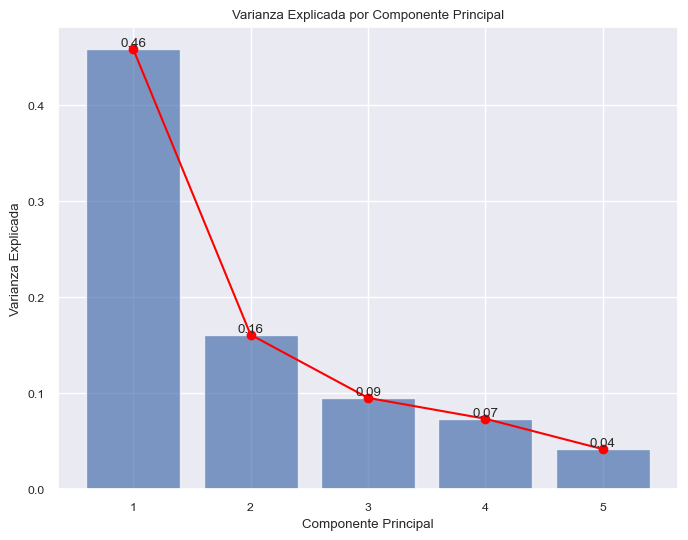

In [360]:

componentes_principales = range(1, len(explained_variance) + 1)


plt.figure(figsize=(8, 6))
plt.bar(componentes_principales, explained_variance, alpha=0.7)


for i, var_exp in enumerate(explained_variance):
    plt.text(i + 1, var_exp, f"{var_exp:.2f}", ha='center', va='bottom')


plt.plot(componentes_principales, explained_variance, marker='o', linestyle='-', color = 'red')


plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.show()

In [361]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(5)], index = df_processed.columns)
print("Cargas de variables en los componentes:")
print(loadings)

Cargas de variables en los componentes:
                                                         PC1       PC2  \
Crecimiento del PIB (% anual)                       0.037201 -0.005615   
Inversión extranjera directa, entradas netas (%... -0.019459 -0.015510   
Índice de Gini                                      0.204198 -0.295915   
Proporción de escaños ocupados por mujeres en l... -0.069272 -0.155468   
Participación laboral femenina (% de la poblaci...  0.066278 -0.428556   
Emisiones de CO2 (toneladas métricas per cápita)   -0.189149  0.012794   
Energía renovable consumida (% del total de ene...  0.537743 -0.202870   
Deforestación neta (% del cambio de cobertura f... -0.018559 -0.724470   
Tasa de alfabetización de adultos (% de persona... -0.322124 -0.215142   
Gastos en educación (% del PIB)                    -0.040792 -0.034178   
Esperanza de vida escolar (años)                   -0.487764 -0.171667   
Tasa de desempleo (% de la población activa)       -0.020418  0.225718  

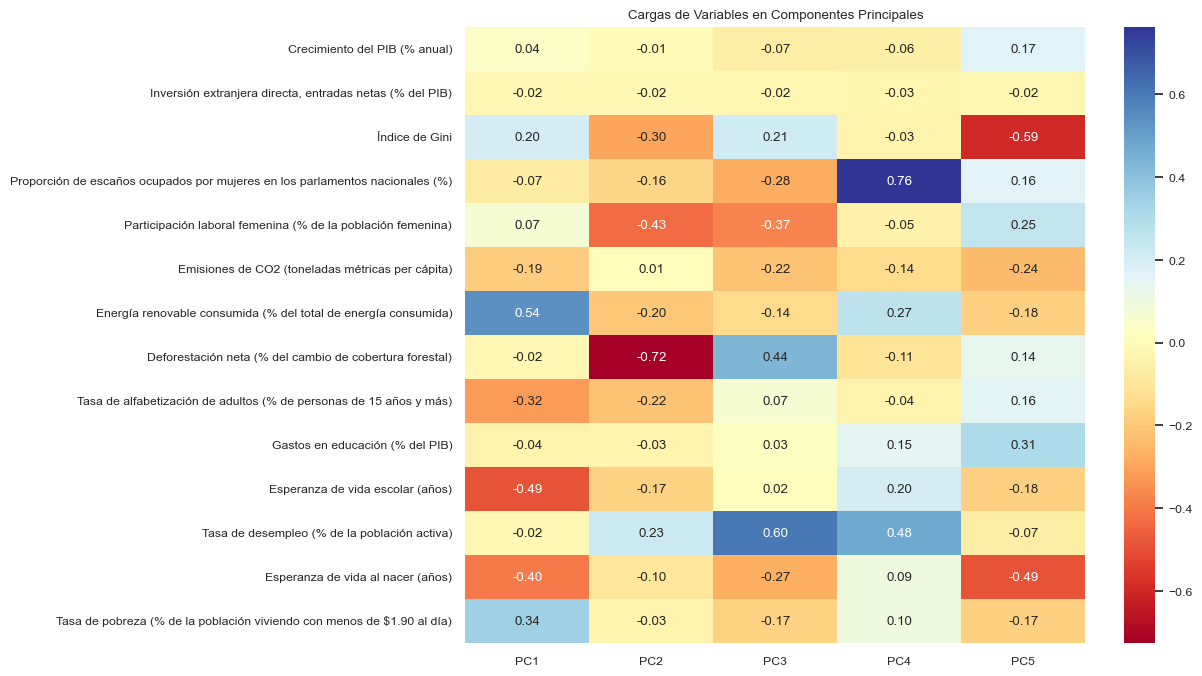

In [362]:
sns.set(font_scale=0.8)


plt.figure(figsize=(10, 8))


sns.heatmap(loadings, annot=True, cmap="RdYlBu", fmt=".2f")

plt.title("Cargas de Variables en Componentes Principales")


plt.show()


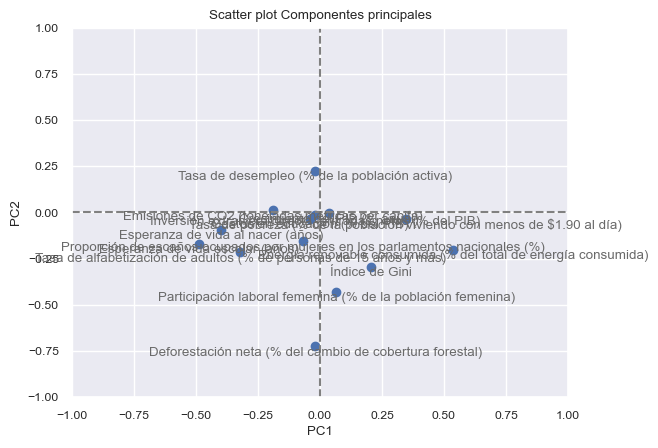

In [363]:
plt.scatter(loadings['PC1'],loadings['PC2'] )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot Componentes principales')


plt.xlim(-1, 1)
plt.ylim(-1, 1)

for label, x, y in zip(loadings.index, loadings['PC1'], loadings['PC2']):
    plt.text(x, y, label, ha='center', va='top', color = 'dimgray')


plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')


plt.show()

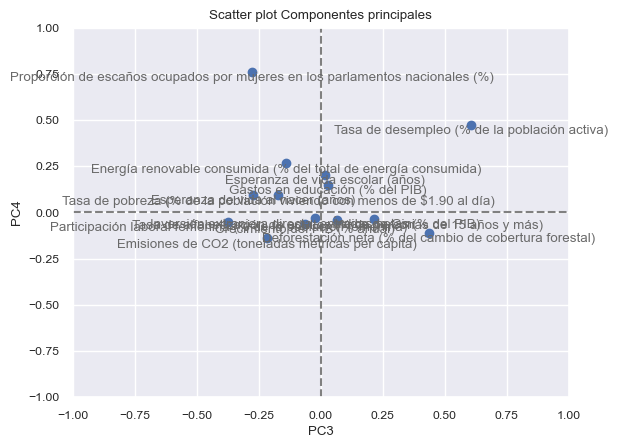

In [364]:
plt.scatter(loadings['PC3'],loadings['PC4'] )

plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('Scatter plot Componentes principales')


plt.xlim(-1, 1)
plt.ylim(-1, 1)

for label, x, y in zip(loadings.index, loadings['PC3'], loadings['PC4']):
    plt.text(x, y, label, ha='center', va='top', color = 'dimgray')


plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')


plt.show()

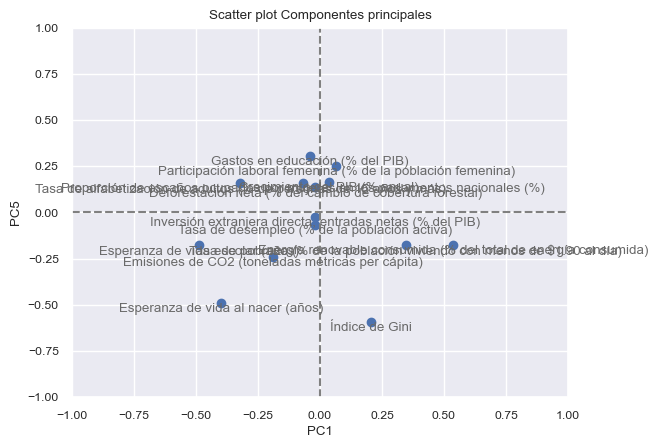

In [381]:
plt.scatter(loadings['PC1'],loadings['PC5'] )

plt.xlabel('PC1')
plt.ylabel('PC5')
plt.title('Scatter plot Componentes principales')


plt.xlim(-1, 1)
plt.ylim(-1, 1)

for label, x, y in zip(loadings.index, loadings['PC1'], loadings['PC5']):
    plt.text(x, y, label, ha='center', va='top', color = 'dimgray')


plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')


plt.show()

In [365]:
print(indices)

[[ 0.13564429  0.5100964   0.19753363  0.11496385  0.05287087]
 [ 0.71217185 -0.06392495 -0.10879152  0.1327429   0.08409153]
 [ 0.99119272  0.08570047 -0.09835959 -0.06514211 -0.04176697]
 ...
 [-0.08031521  0.75619205  0.52697489 -0.09949578 -0.00116038]
 [ 0.79675086 -0.33124123  0.17928861 -0.04796723 -0.09008319]
 [ 0.99987789 -0.27567144  0.0379208   0.17626592 -0.19410099]]


# K Means

### numero optimo de Kmeans

In [366]:
print(indices)

[[ 0.13564429  0.5100964   0.19753363  0.11496385  0.05287087]
 [ 0.71217185 -0.06392495 -0.10879152  0.1327429   0.08409153]
 [ 0.99119272  0.08570047 -0.09835959 -0.06514211 -0.04176697]
 ...
 [-0.08031521  0.75619205  0.52697489 -0.09949578 -0.00116038]
 [ 0.79675086 -0.33124123  0.17928861 -0.04796723 -0.09008319]
 [ 0.99987789 -0.27567144  0.0379208   0.17626592 -0.19410099]]


In [367]:
max_k = 10  
distortions = find_optimal_k(indices, max_k)

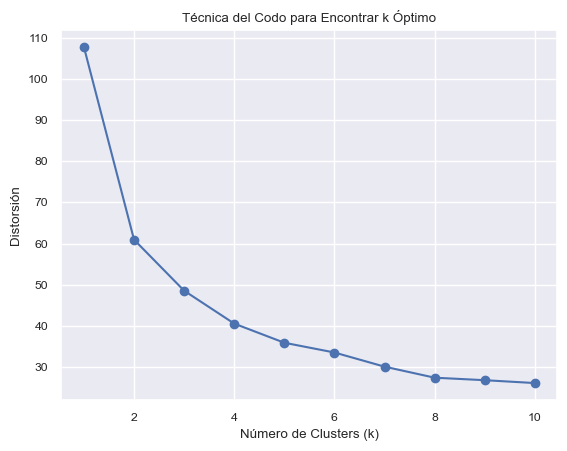

In [368]:
plt.plot(range(1, max_k + 1), distortions, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distorsión')
plt.title('Técnica del Codo para Encontrar k Óptimo')
plt.show()

In [369]:
optimal_k = 4  # Supongamos que el codo está en k=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(indices)

In [370]:
df_clusters = pd.DataFrame(indices, columns=[f'Component {i}' for i in range(1, indices.shape[1] + 1)])
df_clusters['Cluster'] = clusters

In [371]:
cluster_counts = df_clusters['Cluster'].value_counts().sort_index()

C:\Users\santi\AppData\Local\Temp\ipykernel_22392\447291984.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


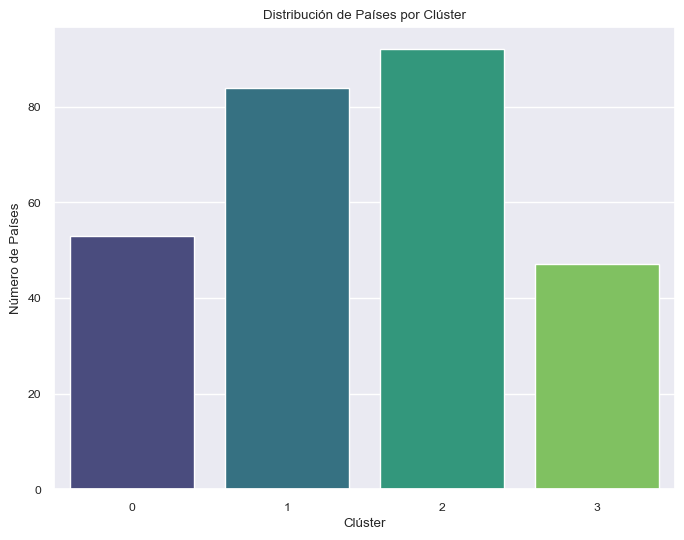

In [372]:
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Distribución de Países por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Número de Países')
plt.show()

In [373]:
df_clusters_with_country = df_clusters.merge(df[['country']], left_index=True, right_index=True)


In [374]:
df_clusters_with_country

,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster,country
0,0.135644,0.510096,0.197534,0.114964,0.052871,3,Afghanistan
1,0.712172,-0.063925,-0.108792,0.132743,0.084092,0,Africa Eastern and Southern
2,0.991193,0.085700,-0.098360,-0.065142,-0.041767,0,Africa Western and Central
3,-0.216878,-0.016093,-0.020582,0.252002,0.017515,2,Albania
4,-0.285077,0.522897,0.146429,0.152943,-0.101996,3,Algeria
...,...,...,...,...,...,...,...
271,-0.215217,0.544290,0.469898,0.365826,-0.152863,3,West Bank and Gaza
272,-0.019555,0.059173,-0.044304,-0.049793,0.073540,1,World
273,-0.080315,0.756192,0.526975,-0.099496,-0.001160,3,"Yemen, Rep."
274,0.796751,-0.331241,0.179289,-0.047967,-0.090083,0,Zambia


In [375]:
iso_a3 = coco.convert(names=df_clusters_with_country['country'], to='ISO3')

In [376]:
df_clusters_with_country['iso_a3'] = iso_a3

In [377]:
df_clusters_with_country

,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster,country,iso_a3
0,0.135644,0.510096,0.197534,0.114964,0.052871,3,Afghanistan,AFG
1,0.712172,-0.063925,-0.108792,0.132743,0.084092,0,Africa Eastern and Southern,not found
2,0.991193,0.085700,-0.098360,-0.065142,-0.041767,0,Africa Western and Central,not found
3,-0.216878,-0.016093,-0.020582,0.252002,0.017515,2,Albania,ALB
4,-0.285077,0.522897,0.146429,0.152943,-0.101996,3,Algeria,DZA
...,...,...,...,...,...,...,...,...
271,-0.215217,0.544290,0.469898,0.365826,-0.152863,3,West Bank and Gaza,PSE
272,-0.019555,0.059173,-0.044304,-0.049793,0.073540,1,World,not found
273,-0.080315,0.756192,0.526975,-0.099496,-0.001160,3,"Yemen, Rep.",YEM
274,0.796751,-0.331241,0.179289,-0.047967,-0.090083,0,Zambia,ZMB


In [382]:
df_clusters_with_country.to_csv('../output/df_clusters_with_country.csv', index=False)

In [378]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Fusionar los datos del mapa con los clústeres de los países
world_with_clusters = world.merge(df_clusters_with_country, on='iso_a3', how='left')


C:\Users\santi\AppData\Local\Temp\ipykernel_22392\3025213652.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 1500x1000 with 0 Axes>

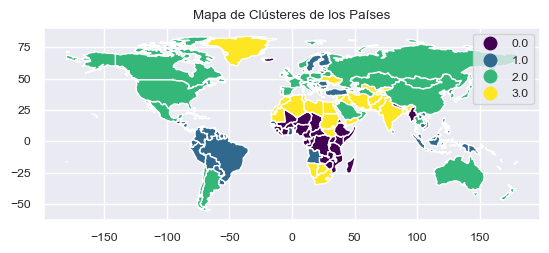

In [379]:
plt.figure(figsize=(15, 10))
world_with_clusters.plot(column='Cluster', categorical=True, legend=True, cmap='viridis')
plt.title('Mapa de Clústeres de los Países')
plt.show()

### Componente Principal 1 (PC1):

Características más influyentes: Energía renovable consumida (% del total de energía), Tasa de pobreza (% de la población viviendo con menos de $1.90 al día), Índice de Gini.
Interpretación: Este componente parece estar relacionado con la distribución del ingreso y la calidad de vida, con un enfoque en el desarrollo sostenible y la reducción de la pobreza.

### Componente Principal 2 (PC2):

Características más influyentes: Participación laboral femenina (% de la población femenina), Tasa de desempleo (% de la población activa), Tasa de alfabetización de adultos (% de personas mayores de 15 años).
Interpretación: Este componente parece estar relacionado con la participación económica y educativa de las mujeres, así como con la situación laboral y educativa en general.

### Componente Principal 3 (PC3):

Características más influyentes: Proporción de escaños ocupados por mujeres en los parlamentos nacionales,Deforestación neta (% del cambio de cobertura forestal).
Interpretación: Este componente parece estar relacionado con cuestiones de equidad de género y conservación del medio ambiente, con un enfoque en la representación política de las mujeres y la protección de los recursos naturales.


### Componente Principal 4 (PC4):

Características más influyentes: Esperanza de vida escolar (años), Gastos en educación (% del PIB), Energía renovable consumida (% del total de energía).
Interpretación: Este componente parece estar relacionado con la educación y la sostenibilidad, con un enfoque en la inversión en educación y el uso de fuentes de energía renovable.

### Componente Principal 5 (PC5):

Características más influyentes: Participación laboral femenina (% de la población femenina), Emisiones de CO2 (toneladas métricas per cápita), Crecimiento del PIB (% anual).
Interpretación: Este componente parece estar relacionado con el desarrollo económico y la sostenibilidad ambiental, con un enfoque en la participación laboral de las mujeres y las emisiones de carbono.
Este análisis nos proporciona una comprensión inicial de las características más relevantes asociadas con cada componente principal, lo que nos ayudará a interpretar qué representan los clusters en función de estas características.

### Cluster 0: 

Estos países tienen altos niveles de pobreza, Mucha desigualdad en cuanto a indice de Gini y Ocupacion en cargos gubernamentales y trabajos por mujeres, Bajos niveles de educacion y bajo nivel de alfabetización.

### Cluster 1

Este cluster muestra una representación significativa de países con alta proporción de escaños ocupados por mujeres en legislaturas nacionales y tambien alta ocupacion de mujeres laboralmente, tambien muestra paises con indices medioambientales buenos con baja generacion de C02 y baja deforestacion neta.

### Cluster 2

Este cluster muestra muestra una representación significativa de países con alta proporción de escaños ocupados por mujeres en legislaturas nacionales y tambien alta ocupacion de mujeres laboralmente, tambien mustra paises con un alto crecimiento economico y baja pobreza, la mayoria de los paises de este cluster tambien muestran una gran generacion de C02 y una alta deforestacion. Los paises de este cluster tambien muestran los mejores indices educacionales con una alta alfabetizacion y un gran gasto en educacion segun el porcentaje del pib

### Cluster 3:

Estos paises se caracterizan por tener un alto crecimiento economico reflejado en el PIB, pero con bajos indices medioambientales con una gran generacion de C02, alta deforestacion neta y con niveles de igualdad laboral en las mujeres extremadamente bajos

